# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [214]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [215]:
class Perceptron:
    def __init__(self, iterations=100):
        self.iterations = iterations
        self.w = None
    
    def fit(self, X, y):
        row = len(y)
        col = len(X[0])
        self.w = [1]*(col + 1)
        prov = 0
        for el in range(len(y)):
            if y[el] == y[0]:
                y[el] = 1
            else:
                y[el] = -1
                
        for i in range(self.iterations):
            for j in range(row):
                scal = self.w[0]
                for k in range(col):
                    scal += self.w[k+1]*X[j][k]
                if np.sign(scal) != y[j]:
                    prov = 1
                    self.w[0] = self.w[0] + y[j]
                    self.w[1:] = [(self.w[i+1] + y[j]*X[j][i]) for i in range(col)]
                    
            if prov == 0:
                break

            
    def predict(self, X):
        row = len(X)
        col = len(X[0])
        y_pred = [0]*row
        for i in range(row):
            scal = self.w[0]
            for k in range(col):
                scal += self.w[k+1]*X[i][k]
            y_pred[i] = int(np.sign(scal))
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

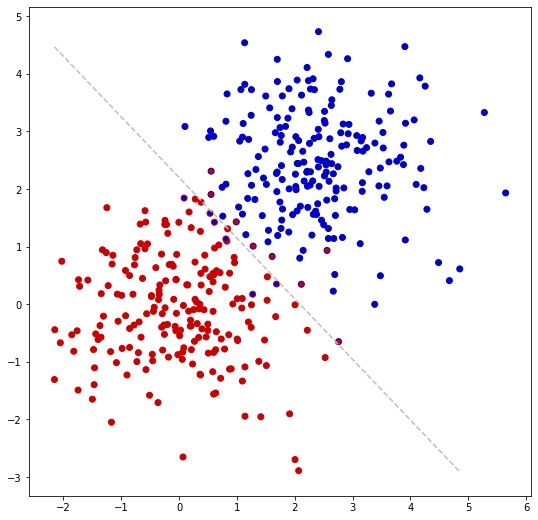

In [82]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

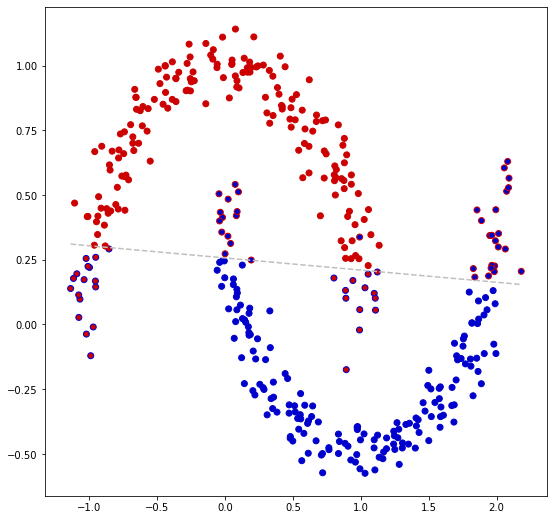

In [83]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [216]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.iterations = iterations
        self.w = None
    
    def fit(self, X, y):
        row = len(y)
        col = len(X[0])
        self.w = [1]*(col + 1)
        proc_min = 1
        w_0 = [1]*(col + 1)
        
        for el in range(len(y)):
            if y[el] == y[0]:
                y[el] = 1
            else:
                y[el] = -1
                
        for i in range(self.iterations):
            prov = 0
            for j in range(row):
                scal = w_0[0]
                for k in range(col):
                    scal += w_0[k+1]*X[j][k]
                if np.sign(scal) != y[j]:
                    prov += 1
                    w_0[0] = w_0[0] + y[j]
                    w_0[1:] = [(w_0[i+1] + y[j]*X[j][i]) for i in range(col)]
            
            if prov == 0:
                self.w = w_0
                break
            else:
                if (prov/row) < proc_min:
                    proc_min = prov/row
                    self.w = w_0

            
    def predict(self, X):
        row = len(X)
        col = len(X[0])
        y_pred = [0]*row
        for i in range(row):
            scal = self.w[0]
            for k in range(col):
                scal += self.w[k+1]*X[i][k]
            y_pred[i] = int(np.sign(scal))
        return y_pred

In [217]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

0.04


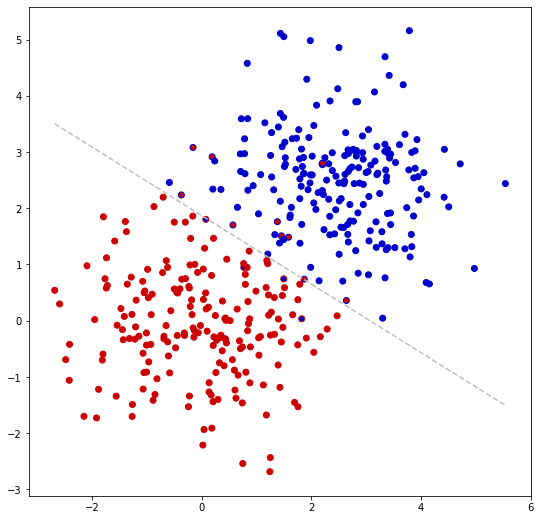

In [139]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

0.155


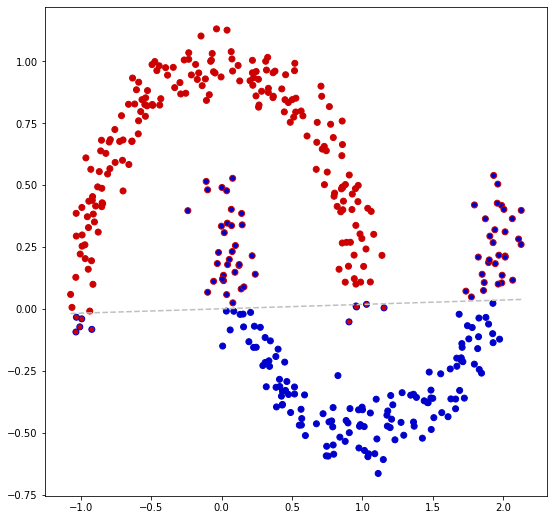

In [138]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [218]:
# первая компонента - это среднее количество единиц в тез столбцах, что в первой строке покрашены более 0.5 интенсивно
# вторая компонента - отношение закрашеных клеточек ко всем
def transform_images(images):
    l = len(images)
    row = len(images[0])
    col = len(images[0][0])
    X = [[0, 0] for i in range(l)]
    for i in range(l):
        white = []
        for k in range(col):
            if images[i][0][k] > 0.5:
                white_0 = 0
                for j in range(row):
                    if images[i][j][k] == 1:
                        white_0 += images[i][j][k]
                white.append(white_0/8)
        if len(white) > 0:
            X[i][0] = np.mean(white)
        
        white = 0
        for j in range(row):
            for k in range(col):
                if images[i][j][k] != 0:
                    white += images[i][j][k] 
        X[i][1] = white/(row*col)
   
    
    
    return np.array(X)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [219]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

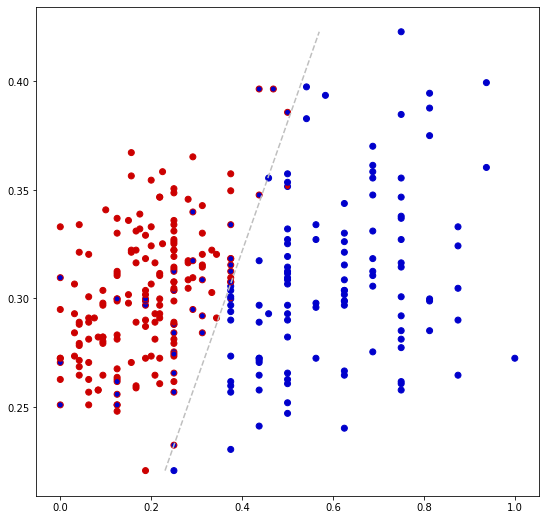

Accuracy: 0.9315068493150684


In [220]:
c = Perceptron(iterations=1000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
for i in range(len(y_test)):
    if y_test[i] == 5:
        y_test[i] = -1
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

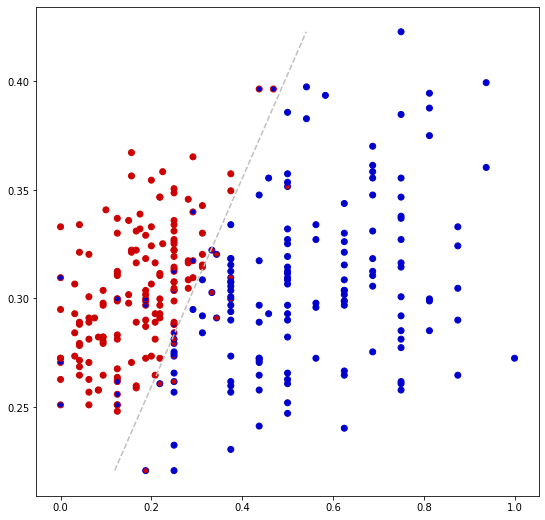

Accuracy: 0.9452054794520548


In [221]:
c = PerceptronBest(iterations=10000)
c.fit(X_train, y_train)
for i in range(len(y_test)):
    if y_test[i] == 5:
        y_test[i] = -1
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [211]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=1000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.0917512261119567


In [222]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=1000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))

print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.0917512261119567
